# Create Fake Binaries

In [1]:
import os, sys
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/stella/')
sys.path.insert(1, '/Users/azib/Documents/open_source/nets2/scripts/')
import numpy as np
from utils import *
import build_synthetic_set as models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman
import warnings
from astroquery.mast import Catalogs
import astropy.constants as const
import time as ti
import re
import pickle
import signal

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
files = glob('../data/eleanor/**/*.fits', recursive=True)
random.shuffle(files)

In [3]:
folder = '../fake-binaries'

In [4]:
def timeout_handler(signum, frame):
    raise TimeoutError("Timeout reached.")

### Load the star

In [5]:
target_IDs = [int(re.search(r"(\d{16})", filename).group(1).lstrip('0')) for filename in files]

In [6]:
# # Define the minimum and maximum periods
# period_min = 2
# period_max = 700.0

# # Generate random values from a uniform distribution between log10(period_min) and log10(period_max)
# num_planets = 5000  # Larger number for better visualization
# log_periods = np.random.uniform(np.log10(period_min), np.log10(period_max), size=num_planets)

# # Convert the log-scale values back to linear scale
# periods = 10 ** log_periods

# # Plot the histogram
# plt.figure(figsize=(8, 6))
# plt.hist(periods, bins=50, edgecolor='black')
# plt.xlabel('Period (days)')

# plt.title('Log Uniform Distribution')
# plt.xlim(period_min, period_max)
# plt.savefig('log-dist.png',dpi=200)
# plt.show()

In [7]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 2:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

In [8]:
# Define the power law exponent (alpha)
# Larger values of alpha will skew the distribution more towards shorter periods
alpha = 1

# Define the minimum and maximum periods
period_min = 15
period_max = 700.0

num_planets = 1
max_retries = 5
retry_delay = 1
timeout_duration = 5

TIC_table = Catalogs.query_object(f'TIC 270577175', catalog="TIC")
r_star = TIC_table['rad'][0]
m_star = TIC_table['mass'][0]

os.makedirs(folder, exist_ok=True)


In [9]:
times = []
ticid = []
injected_lcs = []
limbs = []
failed_iterations = 0
min_snr = 3
max_snr = 20
window_size = 84

for target_ID in tqdm(files[0:500]):  # Iterate through each target ID in the dictionary keys

    
    for i in np.arange(0,num_planets):
        lc, lc_info = import_lightcurve(target_ID,drop_bad_points=True)
        
        
        ### CREATE COPY OF LIGHTCURVE
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        tic = lc_info['TIC_ID']
        lcc = lcc['TIME','PCA_FLUX','QUALITY','FLUX_ERR']
        
        ### INTERPOLATE THE COPIED LIGHTCURVE 
        time, flux, quality, real, flux_error = clean_data(lcc)

        ### DIFF OF ORIGINAL LIGHTCURVE
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]
        retries = 0

        # Flatten the original and downloaded light curves
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)


        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(timeout_duration)

        ### SET SNR AND RMS
        random_snr = np.random.uniform(min_snr,max_snr)
        rms = np.nanstd(flat_flux)
        A = rms * random_snr
        
        while retries < max_retries:
            try:
                params = batman.TransitParams()
                random_value = np.random.uniform(0,1)
                params.per = period_min * (period_max / period_min) ** (random_value ** (1 / alpha))
                
                valid_time_found = False    
                iteration = 0
                
                while not valid_time_found and iteration < 10:
                    params.t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1]) #lc['TIME'][0] + random.uniform(0.0, random.uniform(0.0, params.per))
                    valid_t0 = False
                    
                    for index in large_gaps_indices:
                        start_time = lc['TIME'][index] - 1
                        end_time = lc['TIME'][index + 1] + 1
                        
                        if start_time <= params.t0 <= end_time:
                            break
                        elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(params.t0 - lc['TIME'][index + 1]) < 1.5:
                            break
                        elif index > 0 and diff[index - 1] > 2 and abs(params.t0 - lc['TIME'][index]) < 1.5:
                            break
                        elif params.t0 <= lc['TIME'][0] + 2:
                            break
                        elif params.t0 >= lc['TIME'][-1] - 2:
                            break
                    else:
                        
                        valid_t0 = True

                    if valid_t0:
                        # Check if all data points within the window are non-interpolated
                        window_start = np.argmin(np.abs(time - (params.t0 - window_size * np.median(np.diff(time)))))
                        window_end = np.argmin(np.abs(time - (params.t0 + window_size * np.median(np.diff(time))))) + 1
                        if np.all(real[window_start:window_end] == 1):
                            valid_time_found = True
                        #valid_time_found = True
                    #iteration += 1# Check if all data points within the window are non-interpolated

                    
                params.rp = np.sqrt(A) 
                params.a = (((const.G.value * m_star * const.M_sun.value * (params.per * 86400.) ** 2) / (4. * (np.pi ** 2))) ** (1. / 3)) / (r_star * const.R_sun.value)
                params.inc = 90 #np.random.uniform(88.0,90.0)
    
                ## considering inclination using impact parameter
                # b = np.random.uniform(0, 1)
                
                # # Calculate the inclination angle (i) from the impact parameter
                # params.inc = np.arccos(b / (params.a * (1 + params.rp))) * 180 / np.pi
                
                params.ecc = 0.
                params.w = 90.       
                params.limb_dark = "linear"
    
                ld_coeff = np.random.uniform(0.1,1)
                params.u = [ld_coeff]
                
                m = batman.TransitModel(params, time,fac = 0.02)
                batman_flux = m.light_curve(params)
    
                # Check if the minimum value of batman_flux is 1 (flat line)
                if np.min(batman_flux) == 1:
                    retries += 1
                    if retries == max_retries:
                        failed_iterations += 1
                    else:
                        ti.sleep(retry_delay)
                    continue  
    
                break 
            except TimeoutError:
                signal.alarm(0)
                failed_iterations += 1
                break

        
            except Exception as e:
                if "Convergence failure in calculation of scale factor for integration step size" in str(e):
                    retries += 1
                    if retries == max_retries:
                        failed_iterations += 1
                    else:
                        ti.sleep(retry_delay)
                else:
                    raise e

        signal.alarm(0)

        try:
            injected_flux = batman_flux * (flux/np.nanmedian(flux))
            fluxerror = np.array(flux_error)/np.nanmedian(flux)
        except ValueError as e:
            if "operands could not be broadcast together with shapes" in str(e):
                retries += 1
                if retries == max_retries:
                    failed_iterations += 1
                else:
                    ti.sleep(retry_delay)
                continue
            else:
                raise e    

   
        times.append(params.t0)
        ticid.append(lc_info['TIC_ID'])
        filename = f"{folder}/{lc_info['TIC_ID']}_sector07-exoplanet.npy"
        np.save(filename, [time, injected_flux, fluxerror])
        

100%|█| 500/500 [00:59<00:00,  8.


In [10]:
data = pd.DataFrame(data=[ticid,times]).T
data.columns = ['TIC','tpeak']
data.TIC = data.TIC.astype(int)
table = Table.from_pandas(data)

table.write('catalog-fake-binaries.txt', format='ascii', overwrite=True) 

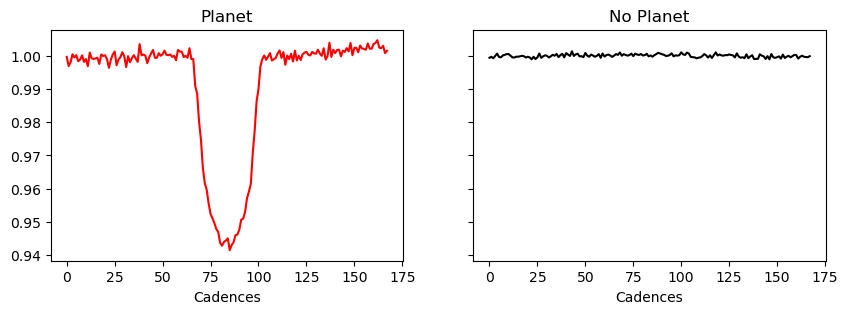

In [12]:
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[0]], 'r')
ax1.set_title('Planet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[0]], 'k')
ax2.set_title('No Planet')
ax2.set_xlabel('Cadences');

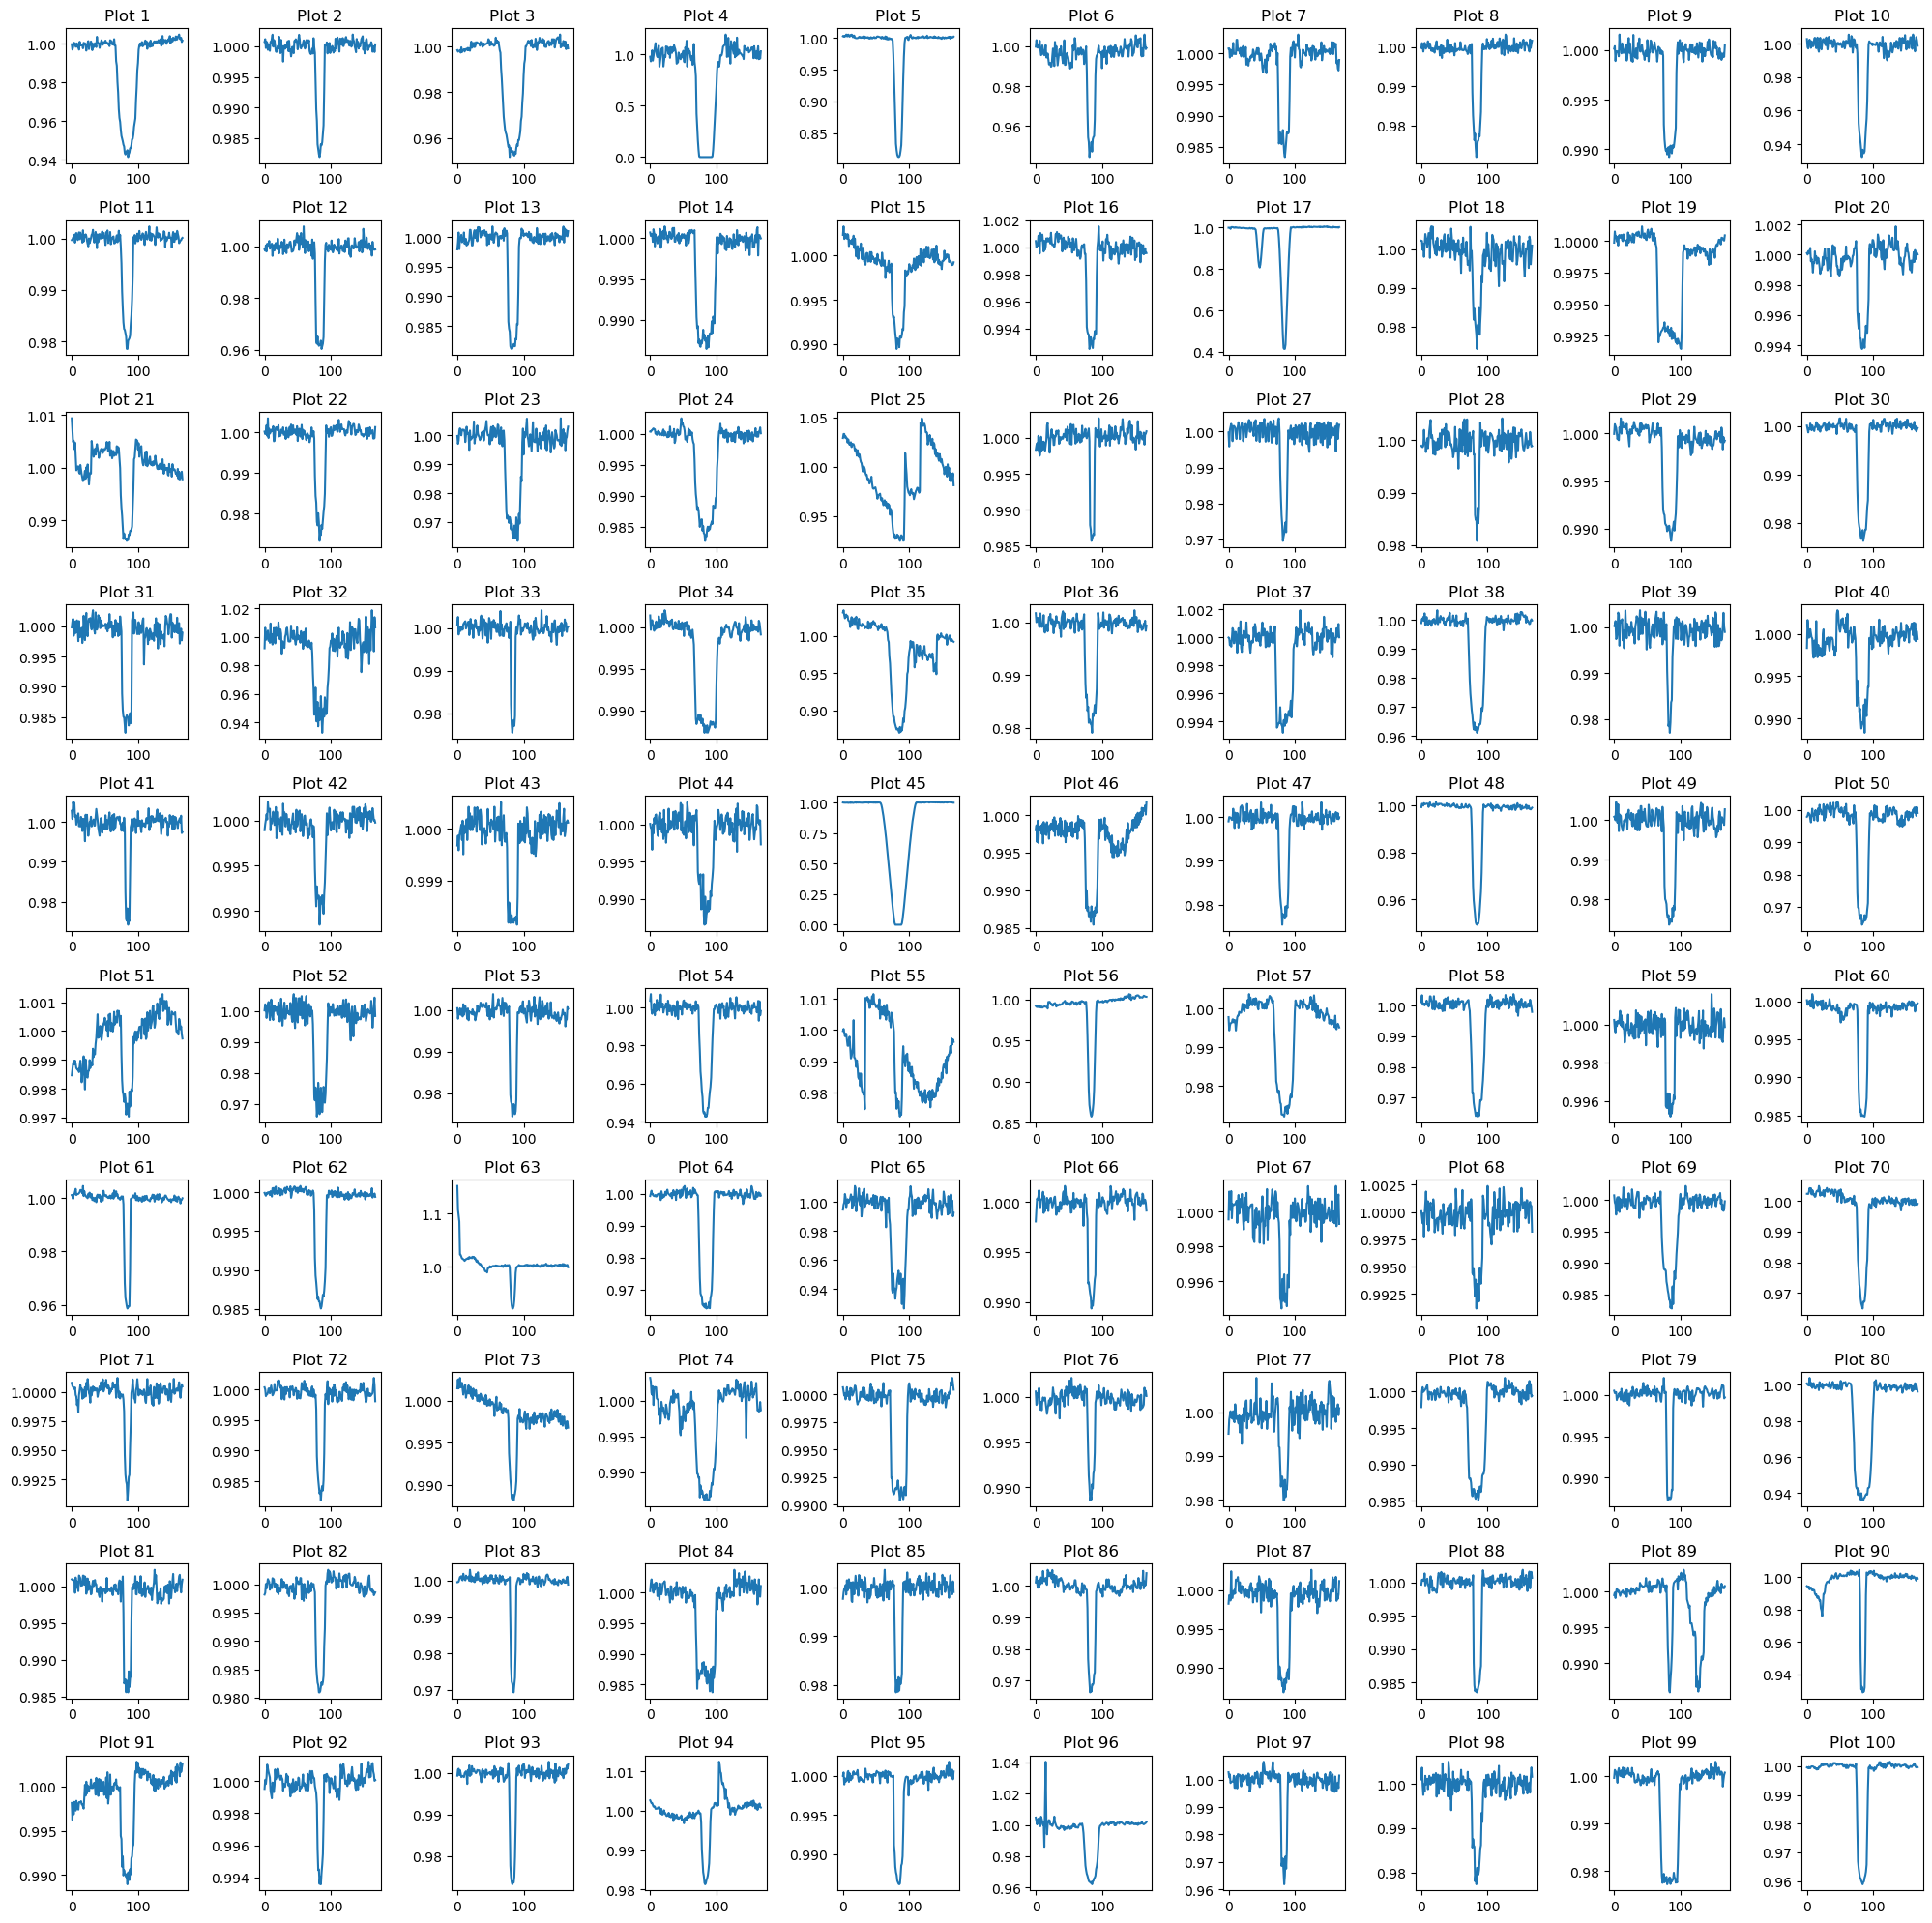

In [15]:
dsmodels = ds.train_data[ind_pc]
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig('exoplanet-models.png',dpi=200)
    plt.show()  # Show the grid of plots
    break

## Combine

In [19]:
ds2 = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/eleanor-lite-models/',
                         catalog='/Users/azib/Documents/open_source/nets2/notebooks/catalog-eleanor-lite.txt',cadences=168,training=0.8,merge_datasets=True,other_datasets=ds)

Reading in training set files.


100%|█| 5017/5017 [00:04<00:00, 1011.10it/s]


8 positive classes (flare)
8122 negative classes (no flare)
0.0% class imbalance



In [24]:
ds2.reformat_data

<bound method FlareDataSet.reformat_data of <stella.preprocessing_flares.FlareDataSet object at 0x30dec4dc0>>

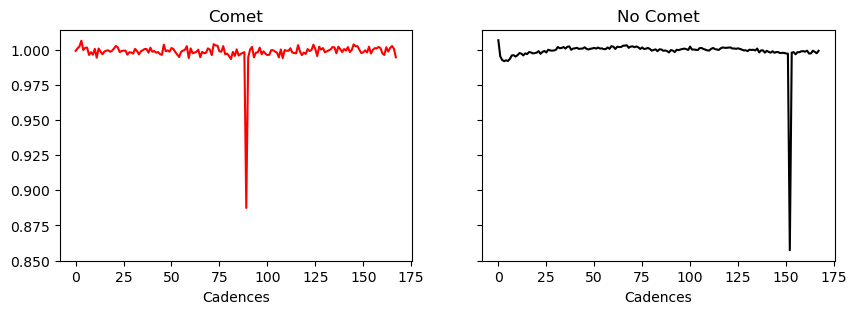

In [25]:
ind_pc = np.where(ds2.train_labels==1)[0] # Flares
ind_nc = np.where(ds2.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds2.train_data[ind_pc[5]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds2.train_data[ind_nc[800]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

In [ ]:
# dsnomodels = ds2.train_data[ind_nc]
# num_sets = dsnomodels.shape[0] // 100

# for set_index in range(num_sets):
#     start_index = set_index * 100
#     end_index = min((set_index + 1) * 100, dsnomodels.shape[0])  # Ensure not to exceed the length of the data

#     # Create a new 10x10 grid of subplots for each set
#     fig, axs = plt.subplots(10, 10, figsize=(20, 20))

#     # Flatten the axes array for easier iteration
#     axs = axs.flatten()

#     # Iterate over the elements in the current set and plot each in the grid
#     for i in range(start_index, end_index):
#         plot_index = i % 100  # Calculate the index within the current grid
#         axs[plot_index].plot(dsnomodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
#         axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

#     # Hide any remaining empty subplots
#     for j in range(end_index - start_index, len(axs)):
#         axs[j].axis('off')

    
#     plt.tight_layout()  # Adjust layout
#     #plt.savefig('exoplanet-models.png',dpi=200)
#     plt.show()  # Show the grid of plots
#     break

In [20]:
data_dict = {}

# Load each .npy file and store in the dictionary
for target_ID in ds.ids:
    filename = f"{folder2}/{target_ID}.npy"
    data = np.load(filename)
    data_dict[target_ID] = data

In [ ]:
{key: data_dict[key] for key in ds.train_data if key in b}

In [ ]:
num_sets = dsmodels.shape[0] // 100

for set_index in range(num_sets):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i+1}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig('exoplanet-models.png',dpi=200)
    plt.show()  # Show the grid of plots
    break